
### Introduction

This notebook shows how to extract the storm surge signal from LINZ tide gauge data at a specific station. Here we use Auckland (AUCT) sea level data previously downloaded (see `download_linz.ipynb` notebook).

### Install necessary python libraries

First install some python libraries, if not already installed in your current python3 environment.

In [1]:
import sys
!{sys.executable} -m pip install GitPython matplotlib wand fpdf

  Using cached GitPython-3.1.29-py3-none-any.whl (182 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 26.1 MB/s eta 0:00:00m eta 0:00:010:0101
  Using cached Wand-0.6.10-py2.py3-none-any.whl (142 kB)
  Using cached fpdf-1.7.2-py2.py3-none-any.whl
  Using cached gitdb-4.0.9-py3-none-any.whl (63 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.8 MB/s eta 0:00:00m eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.0 MB/s eta 0:00:0031m30.9 MB/s eta 0:00:01
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)


#### Clone/install github repositories
Clone MetOcean storm_surge github repository to `/tmp` folder. This repository contain the python scripts necessary to perform all the LINZ sea level data analysis.

In [6]:
## TODO merge to main and remove branch from the clone command
from git import Repo

# Repo.clone_from('git@github.com:metocean/storm_surge.git', '/tmp/storm_surge')
Repo.clone_from('git@github.com:metocean/storm_surge.git', '/tmp/storm_surge', branch='linz_processing')


Clone and install Calypso Science Toto python library. From this library we will use the `LINZfile` class that reads the LINZ NetCDF and readme files into a pandas DataFrame object.

In [5]:
## TODO merge to main and remove branch from the clone command
# Repo.clone_from('git@github.com:calypso-science/Toto.git', ''/tmp/Toto')
Repo.clone_from('git@github.com:calypso-science/Toto.git', '/tmp/Toto', branch="storm_surge_project")
!{sys.executable} -m pip install --no-cache-dir -r /tmp/Toto/requirements.txt
!{sys.executable} -m pip install -e /tmp/Toto

  Cloning https://github.com/python-windrose/windrose to /tmp/pip-req-build-t6pv3iz3
  Running command git clone --filter=blob:none --quiet https://github.com/python-windrose/windrose /tmp/pip-req-build-t6pv3iz3
  Resolved https://github.com/python-windrose/windrose to commit 7342238361b28943063b9b9669cb47bc81f568f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/wesleybowman/UTide.git to /tmp/pip-req-build-elxdzph6
  Running command git clone --filter=blob:none --quiet https://github.com/wesleybowman/UTide.git /tmp/pip-req-build-elxdzph6
  Resolved https://github.com/wesleybowman/UTide.git to commit b2bd8367e132dc896c4a96ff633aeefb45b0a87c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 124.8 MB/s eta 0:00:00
  Preparing metadat

Failed to build pysqlite3
  Running setup.py install for pysqlite3 ... done
Obtaining file:///tmp/Toto
  Preparing metadata (setup.py) ... done
  Running setup.py develop for toto


### Read LINZ sea level data
#### First we read LINZ sea level data previously downloaded.
The `download_linz.ipynb` notebook illustrate how to get NetCDF and readme/information ascii file from the LINZ website. Here we will use data from Auckland LINZ station named "AUCT" as an example.

The `read_linz` method takes two inputs, the full path of LINZ NetCDF file and the station datum. The last is optional and if provided, the code will use the given value to apply sensor vertical drifting corrections and    reference water level around zero. If omitted (default), no offset drifting correction will be applied and the sea level anomalies will be calculated in relation to the time average water level.

In this example we use the New Zealand Vertical Datum 2016, equal to 3.1370 m at Auckland station (https://www.geodesy.linz.govt.nz/gdb/?code=DD1N). The datum heights for other LINZ stations can be found at https://www.linz.govt.nz/guidance/geodetic-system/coordinate-systems-used-new-zealand/vertical-datums/local-mean-sea-level-datums.


In [2]:
import sys
sys.path.append('/tmp/storm_surge/storm_surge/timeseries_processing/linz_waterlevel')
import LINZ

filein = '/tmp/linz/raw/AUCT/AUCT_raw.nc'
dfraw, lon, lat = LINZ.read_linz(filein, 3.1370)

Reading: /tmp/linz/raw/AUCT/AUCT_raw.nc
Processing water levels for sensor 40
Using datum height of 3.1370 m
Reading offset drifting information from sensor 40
Skipping Apr 2009 - Nov 2009: zero point drifting    
Correcting sensor offset drifting Dec 2009 - Apr 2011: 8.85
Correcting sensor offset drifting May 2011 - May 2012: 8.68
Skipping Jun 2012 - Aug 2012: zero point drifting          
Correcting sensor offset drifting Sep 2012 - Dec 2014: 8.41
Correcting sensor offset drifting Jan 2015 - Aug 2017: 8.43
Skipping Sep 2017 - Feb 2019: zero point drifting
Correcting sensor offset drifting Mar 2019 - Dec 2019: 8.52
Skipping Jan 2020 -> zero point drifting
Processing water levels for sensor 41
Using datum height of 3.1370 m
Reading offset drifting information from sensor 41
Correcting sensor offset drifting Apr 2009 - Feb 2011: 8.74
Skipping Mar 2009 - Apr 2009:  zero point drifting     
Correcting sensor offset drifting May 2011 - May 2012: 8.70 
Skipping Jun 2012 - Aug 2012: sensor f

#### Now we select which sensor we want to use.

Each LINZ water level station has data from 2 sensors coded as `40` and `41`. The data processing will use data from 1 sensor only. Executing the following will plot a figure showing the data for both sensors (not shown here as we are using `%matplotlib qt` to be able to interact with the figure). Click on the sensor time series you want to use the data from. Here we chose sensor `40`.

In [3]:
%matplotlib qt
from core_routines.check import plot_graph as select_sensor
import copy
import os
import matplotlib.pyplot as plt

tmpfolder = '/tmp'
df0 = copy.deepcopy(dfraw)

answer = select_sensor([dfraw, dfraw], \
                       ['elev40', 'elev41'], \
                       ['Click on this graph to choose sensor: 40','41'],
                       save=os.path.join(tmpfolder, 'raw_data.png'),
                       eventname='choose')

print('Waiting for button press')
plt.waitforbuttonpress()
print('Continuing')

## switch to right dataframe
if answer['axes'] == '41':
    sensor = '41'
    del df0['elev40']
else:
    sensor = '40'
    del df0['elev41']

print(f'Switching to sensor {sensor}')
df0.rename(columns={f'elev{sensor}':'elev'}, inplace=True)

del df0['time']
        

Waiting for button press
Continuing
Switching to sensor 40


The sea level data is loaded as `pandas DataFrame` shown bellow. We now switch to `%matplotlib inline` to visualize the sea level time series.

                         elev  longitude  latitude
time                                              
2013-01-01 00:00:00  0.335001    174.783   -36.833
2013-01-01 00:01:00  0.323000    174.783   -36.833
2013-01-01 00:02:00  0.312000    174.783   -36.833
2013-01-01 00:03:00  0.303000    174.783   -36.833
2013-01-01 00:04:00  0.292000    174.783   -36.833
...                       ...        ...       ...
2018-01-01 23:55:00 -1.122000    174.783   -36.833
2018-01-01 23:56:00 -1.129000    174.783   -36.833
2018-01-01 23:57:00 -1.136000    174.783   -36.833
2018-01-01 23:58:00 -1.144000    174.783   -36.833
2018-01-01 23:59:00 -1.154000    174.783   -36.833

[2596567 rows x 3 columns]


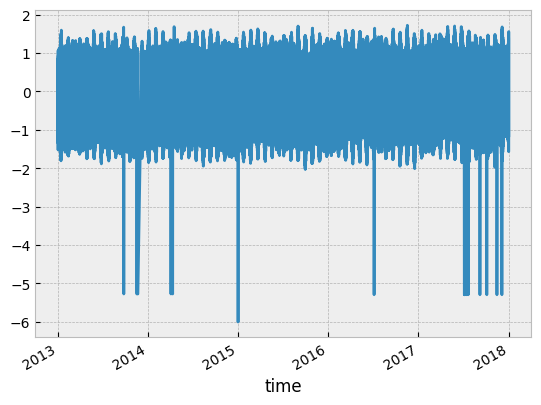

In [4]:
%matplotlib inline

print(df0)
df0['elev'].plot();

### Data cleaning
#### Automatic cleaning
This step performs a number of automatic cleaning processes to the data. Here we enable a phase-space despiking as well as a threshold-based despiking and disable a piecewise fashion detrending (performed at each time segment separated by NaNs). These options can be changed as wanted. More information can be found at ...
Before cleaning, a resample to hourly interval is performed, although this might not play a role in this example that the data is already hourly spaced.
##### TODO fill here path to clean_linz.py

In [5]:
from core_routines.toolbox import clean_linz

phasespace3d = True
despike = True
abs_threshold = 3
detrend_btw_gap = False

df1 = clean_linz(copy.deepcopy(df0),
                 dt=60,
                 phasespace3d=phasespace3d,
                 despike=despike,
                 abs_threshold=abs_threshold,
                 detrend_btw_gap=detrend_btw_gap)

	Fill gap
	Resample to hourly
	Remove spike with phasespace3d
	Remove spike with abs threshold (if value exceeds)
	Finished automatic cleaning


This is how the sea level data looks like after the automatic cleaning. Note that the large negative spikes are now removed from the time series.

                     longitude  latitude    filled  phasespace   despike  \
time                                                                       
2013-01-01 00:00:00    174.783   -36.833  0.335001    0.335001  0.335001   
2013-01-01 01:00:00    174.783   -36.833 -0.254000   -0.254000 -0.254000   
2013-01-01 02:00:00    174.783   -36.833 -0.842000   -0.842000 -0.842000   
2013-01-01 03:00:00    174.783   -36.833 -1.249000   -1.249000 -1.249000   
2013-01-01 04:00:00    174.783   -36.833 -1.335999   -1.335999 -1.335999   
...                        ...       ...       ...         ...       ...   
2018-01-01 19:00:00    174.783   -36.833  1.539000    1.539000  1.539000   
2018-01-01 20:00:00    174.783   -36.833  1.402000    1.402000  1.402000   
2018-01-01 21:00:00    174.783   -36.833  0.796000    0.796000  0.796000   
2018-01-01 22:00:00    174.783   -36.833  0.118000    0.118000  0.118000   
2018-01-01 23:00:00    174.783   -36.833 -0.565000   -0.565000 -0.565000   

           

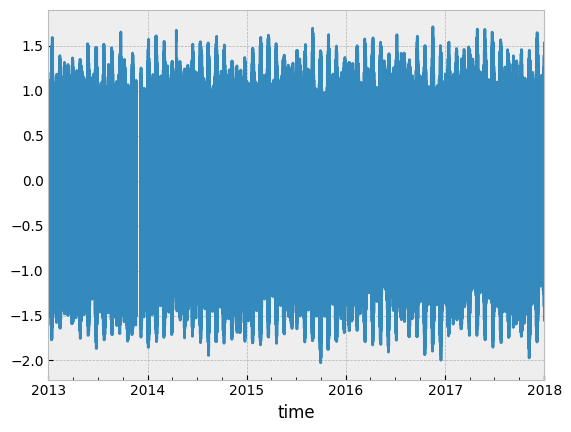

In [6]:
print(df1)
df1['elev'].plot();

#### Manual cleaning
A manual cleaning can also be performed to delete some remaining unwanted data. Here we change back to `%matplotlib qt` to be able to interact with the figure. To delete unwanted data, simply click and hold the mouse left button and slide the mouse throught the x-axis until you cover the desired period. You'll be able to see a light grey background of the data that will be deleted. You can zoom in and out the time series by selecting the magnifying glass icon. When switching the pan or zoom icons on and off, the data that will be deleted is pointed with red markers. Once finished, simply close the figure. Here we delete some data at the beginning of July 2017.

In [7]:
%matplotlib qt
from core_routines.check import plot_graph as clean_manually

answer = clean_manually([df0, df1], ['elev', 'elev'], ['Raw', 'Filter'], save=None, eventname='clean')


Now we add `NaN` to the unwanted data and save the time periods to be printed on the output log file later own.

In [8]:
from core_routines.toolbox import delete_manually
from matplotlib.dates import num2date

deleted_time = {}
if 'delete' in answer:
    df1['clean'] = delete_manually(df1['elev'], answer['delete'])

    for i, time in enumerate(answer['delete']):
        deleted_time[str(i+1)] = 'From %s to %s' % (num2date(time[0]).strftime('%Y-%m-%d %H:00'), num2date(time[1]).strftime('%Y-%m-%d %H:00'))

else:
    df1['clean'] = df1['elev']

df = df1['clean'].copy().to_frame()
df.rename(columns={'clean': 'elev'}, inplace=True)

This is how the final cleaned data looks like.

                         elev
time                         
2013-01-01 00:00:00  0.335001
2013-01-01 01:00:00 -0.254000
2013-01-01 02:00:00 -0.842000
2013-01-01 03:00:00 -1.249000
2013-01-01 04:00:00 -1.335999
...                       ...
2018-01-01 19:00:00  1.539000
2018-01-01 20:00:00  1.402000
2018-01-01 21:00:00  0.796000
2018-01-01 22:00:00  0.118000
2018-01-01 23:00:00 -0.565000

[43848 rows x 1 columns]


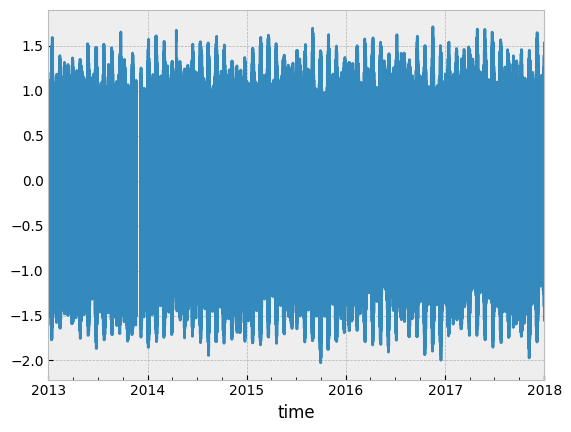

In [9]:
%matplotlib inline

print(df)
df['elev'].plot();

### Extract the storm surge signal

Now the data is clean and ready to be analysed. Here we apply several filterings to the time series to split the sea level in different signals and get the storm surge component. The `cutoff` variable is the filter cutoff time (in hours) to remove tides and inertial oscillations from the total water level and isolate the storm surge signal.

In [10]:
from core_routines.toolbox import do_analysis

# filter cutoff time (in hours) to remove tides and inertial oscillations
cutoff = 30
folderout = '/tmp/linz/processed/AUCT/'
fileout = os.path.join(folderout, 'AUCT_processed.nc')

df = do_analysis(df['elev'], lat, cutoff=cutoff)


	Storing NaNs position
	Detrending
	Tidal analysis
{'trend': False, 'constit': 'auto', 'method': 'ols', 'conf_int': 'linear', 'Rayleigh_min': 2}
solve: matrix prep ... solution ... done.
prep/calcs ... done.
	Monthly mean filtering
	Storm surge filtering
	Skew surge filtering
prep/calcs ... done.


In [11]:
print(df)

                         elev  et     trend      tide      msea  ss  res  \
time                                                                       
2013-01-01 00:00:00  0.335001 NaN -0.160459  0.549299       NaN NaN  NaN   
2013-01-01 01:00:00 -0.254000 NaN -0.160458 -0.032481  0.003357 NaN  NaN   
2013-01-01 02:00:00 -0.842000 NaN -0.160458 -0.577989  0.003192 NaN  NaN   
2013-01-01 03:00:00 -1.249000 NaN -0.160457 -0.980055  0.003016 NaN  NaN   
2013-01-01 04:00:00 -1.335999 NaN -0.160456 -1.126598  0.002833 NaN  NaN   
...                       ...  ..       ...       ...       ...  ..  ...   
2018-01-01 19:00:00  1.539000 NaN -0.121068  1.497714  0.125765 NaN  NaN   
2018-01-01 20:00:00  1.402000 NaN -0.121068  1.319589  0.125760 NaN  NaN   
2018-01-01 21:00:00  0.796000 NaN -0.121067  0.769123  0.125752 NaN  NaN   
2018-01-01 22:00:00  0.118000 NaN -0.121066  0.064518  0.125729 NaN  NaN   
2018-01-01 23:00:00 -0.565000 NaN -0.121065 -0.600380  0.125769 NaN  NaN   

           

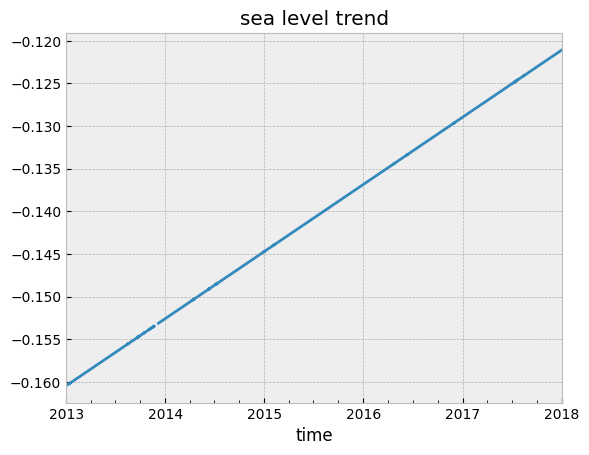

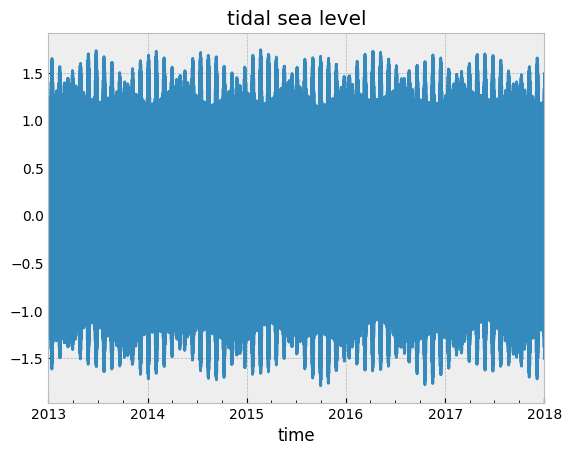

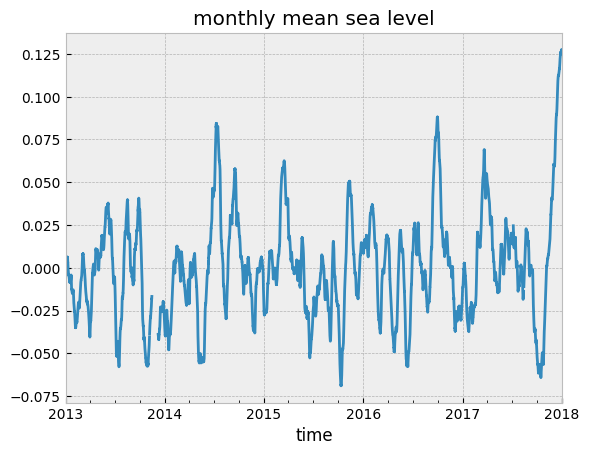

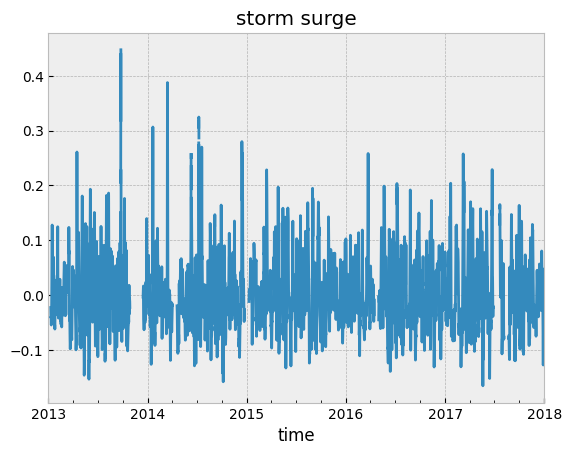

In [12]:
df['trend'].plot(title='sea level trend');

plt.figure();
df['tide'].plot(title='tidal sea level');

plt.figure();
df['msea'].plot(title='monthly mean sea level');

plt.figure();
df['ss'].plot(title='storm surge');


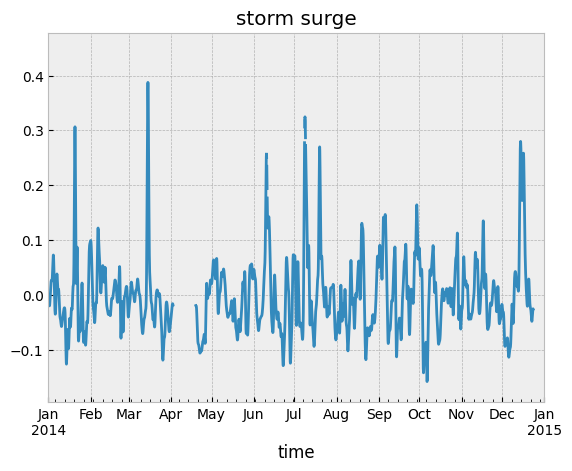

In [13]:
import datetime as dt

plt.figure();
df['ss'].plot(title='storm surge');
plt.xlim(dt.datetime(2014, 1, 1), dt.datetime(2015, 1, 1));


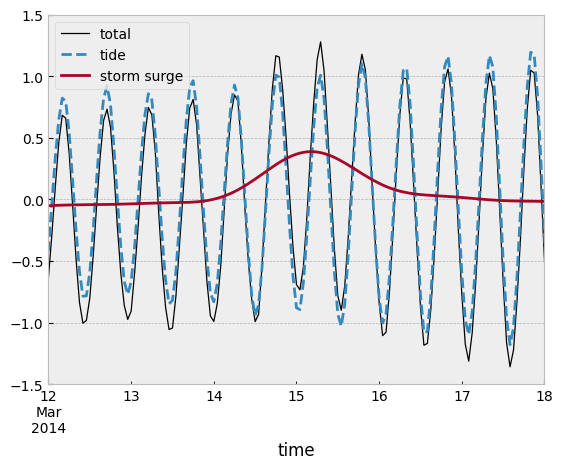

In [14]:
plt.figure();
df['elev'].plot(linewidth=.9, color='k', label='total');
df['tide'].plot(linestyle='--', label='tide');
df['ss'].plot(label='storm surge');
plt.legend(loc='best');

plt.xlim(dt.datetime(2014, 3, 12), dt.datetime(2014, 3, 18));
plt.ylim(-1.5, 1.5);


### Save output files

In [15]:
from core_routines.toolbox import store_data_as_netcdf

folderout = '/tmp/linz/processed/AUCT/'
fileout = os.path.join(folderout, 'AUCT_processed.nc')

# Save the new dataset into a NetCDF
store_data_as_netcdf(df, lon, lat, fileout)


Saving log to /tmp/linz/processed/AUCT/AUCT_log.pdf


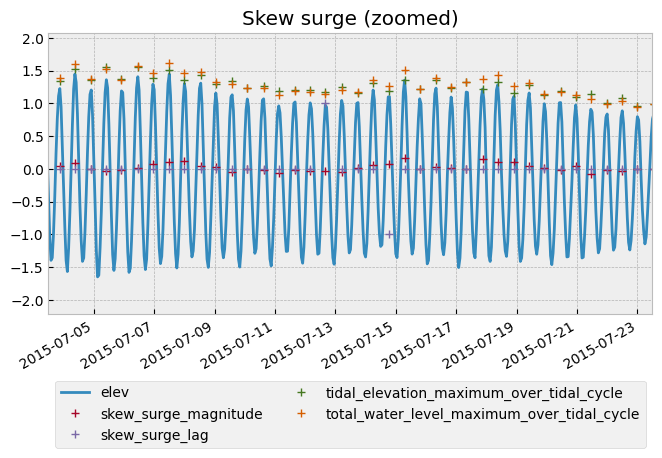

In [16]:
%matplotlib inline

# save a pdf with the parameters used and the different steps taken
pdflog = os.path.join(folderout, 'AUCT_log.pdf')
prefix = 'AUCT'

LINZ.save_pdf(df, df1, pdflog, prefix, filein, fileout, cutoff, sensor, tmpfolder, \
         phasespace3d, despike, abs_threshold, detrend_btw_gap, \
         deleted_time, folderout)

The resulting pdf log showing all the processing steps performed with the sea level data is shown bellow:

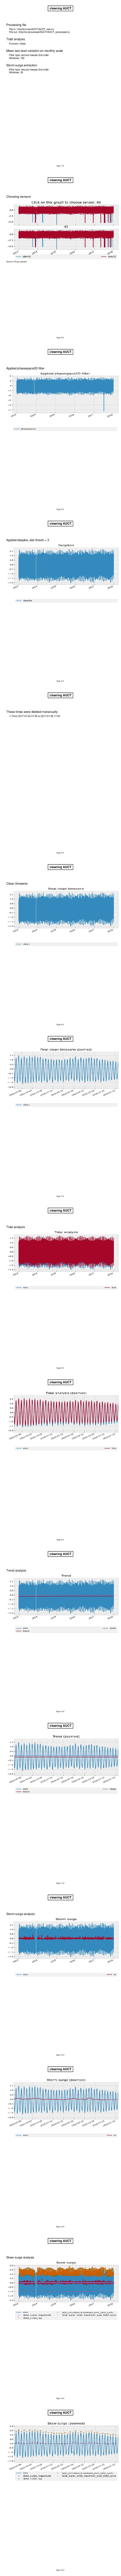

In [17]:
from wand.image import Image

imageFromPdf = Image(filename='/tmp/linz/processed/AUCT/AUCT_log.pdf')
pages = len(imageFromPdf.sequence)  

image = Image(  
  width=imageFromPdf.width,  
  height=imageFromPdf.height * pages  
)  
for i in range(pages):  
  image.composite(  
  imageFromPdf.sequence[i],  
  top=imageFromPdf.height * i,  
  left=0  
)  
image.format="png"  
image 
